# With labeled clusters and hierarchical structure

In [3]:
# use logcounts to calculate PCA and neighbors
import scanpy as sc
import schist
import pertpy as pt
adata = sc.read_h5ad("harber.h5ad")
adata.layers["counts"] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, random_state=1234)
sc.tl.umap(adata)

/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 15215 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)
/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


In [3]:
from schist.inference import fit_model

# 拟合模型
fit_model(
    adata,
    deg_corr=True,           # 是否校正基因差异表达
    n_sweep=10,              # 类似 MCMC sweep 次数
    n_init=100,              # 初始化次数
    collect_marginals=True,  # 是否收集后验边缘分布
    random_seed=5678
)

# 查看细胞群推断结果
adata.obs.head()


100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


,batch,barcode,condition,cell_label,nsbm_level_0,nsbm_level_1,nsbm_level_2,nsbm_level_3,nsbm_level_4,nsbm_level_5,nsbm_level_6
index,,,,,,,,,,,
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor,B1,AAACATACCACAAC,Control,Enterocyte.Progenitor,0,0,2,0,1,0,0
B1_AAACGCACGAGGAC_Control_Stem,B1,AAACGCACGAGGAC,Control,Stem,178,1,1,1,1,0,0
B1_AAACGCACTAGCCA_Control_Stem,B1,AAACGCACTAGCCA,Control,Stem,2,2,12,1,1,0,0
B1_AAACGCACTGTCCC_Control_Stem,B1,AAACGCACTGTCCC,Control,Stem,15,3,1,1,1,0,0
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor,B1,AAACTTGACCACCT,Control,Enterocyte.Progenitor,4,23,11,4,1,0,0


In [4]:
sc.pl.umap(
    adata, color=["nsbm_level_1", "nsbm_level_2", "cell_label"], ncols=3, wspace=0.5
)

In [5]:
import pertpy as pt
tasccoda_model = pt.tl.Tasccoda()
tasccoda_data = tasccoda_model.load(
    adata,
    type="cell_level",
    cell_type_identifier="nsbm_level_1",
    sample_identifier="batch",
    covariate_obs=["condition"],
    levels_orig=["nsbm_level_4", "nsbm_level_3", "nsbm_level_2", "nsbm_level_1"],
    add_level_name=True,
)
tasccoda_data

MuData object with n_obs × n_vars = 9852 × 15258
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'nsbm_level_0', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5', 'nsbm_level_6', 'scCODA_sample_id'
      uns:	'pca', 'neighbors', 'umap', 'schist', 'nsbm_level_1_colors', 'nsbm_level_2_colors', 'cell_label_colors'
      obsm:	'X_pca', 'X_umap', 'CM_nsbm_level_0', 'CM_nsbm_level_1', 'CM_nsbm_level_2', 'CM_nsbm_level_3', 'CM_nsbm_level_4', 'CM_nsbm_level_5', 'CM_nsbm_level_6'
      varm:	'PCs'
      layers:	'counts', 'logcounts'
      obsp:	'distances', 'connectivities'
    coda:	10 x 43
      obs:	'batch', 'condition'
      var:	'n_cells'
      uns:	'tree'

In [6]:
# 不弹窗，返回图像对象
import os
os.environ["QT_QPA_PLATFORM"] = "offscreen"



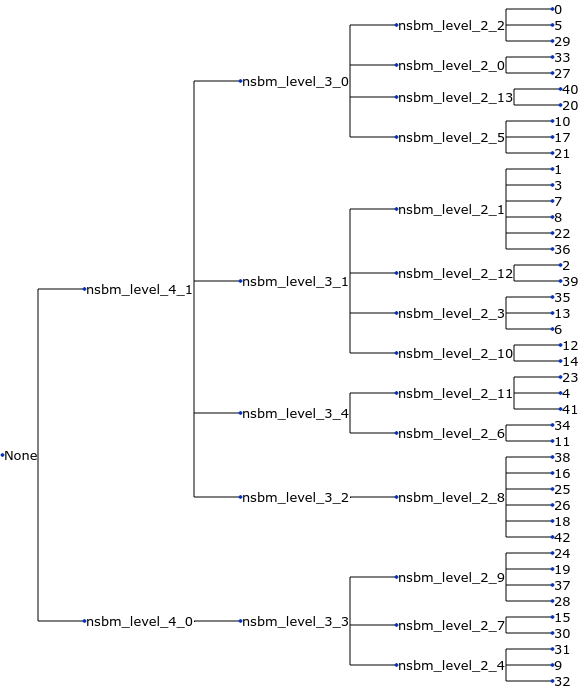

In [7]:
tasccoda_model.plot_draw_tree(tasccoda_data)

In [8]:
tasccoda_model.prepare(
    tasccoda_data,
    modality_key="coda",
    reference_cell_type="18",
    formula="condition",
    pen_args={"phi": 0, "lambda_1": 3.5},
    tree_key="tree",
)

• Zero counts encountered in data! Added a pseudocount of 0.5.


MuData object with n_obs × n_vars = 9852 × 15258
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'nsbm_level_0', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5', 'nsbm_level_6', 'scCODA_sample_id'
      uns:	'pca', 'neighbors', 'umap', 'schist', 'nsbm_level_1_colors', 'nsbm_level_2_colors', 'cell_label_colors'
      obsm:	'X_pca', 'X_umap', 'CM_nsbm_level_0', 'CM_nsbm_level_1', 'CM_nsbm_level_2', 'CM_nsbm_level_3', 'CM_nsbm_level_4', 'CM_nsbm_level_5', 'CM_nsbm_level_6'
      varm:	'PCs'
      layers:	'counts', 'logcounts'
      obsp:	'distances', 'connectivities'
    coda:	10 x 43
      obs:	'batch', 'condition'
      var:	'n_cells'
      uns:	'tree', 'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'

In [9]:
tasccoda_model.run_nuts(
    tasccoda_data, modality_key="coda", rng_key=12345, num_samples=10000, num_warmup=1000
)

sample: 100%|██████████| 11000/11000 [05:39<00:00, 32.42it/s, 63 steps of size 5.33e-02. acc. prob=0.89]


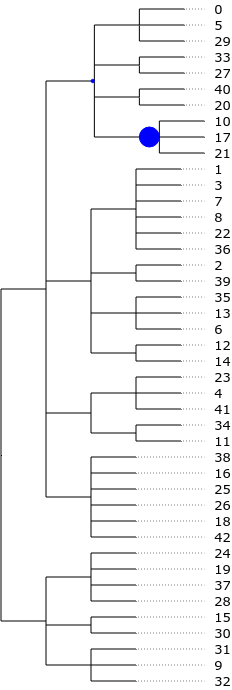

In [10]:
tasccoda_model.plot_draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Salmonella]",
    show_leaf_effects=False,
    show_legend=False,
)

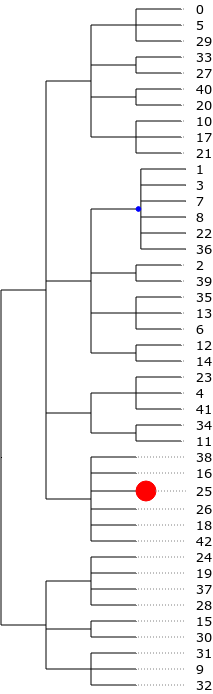

In [11]:
tasccoda_model.plot_draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Hpoly.Day3]",
    show_leaf_effects=False,
    show_legend=False,
)

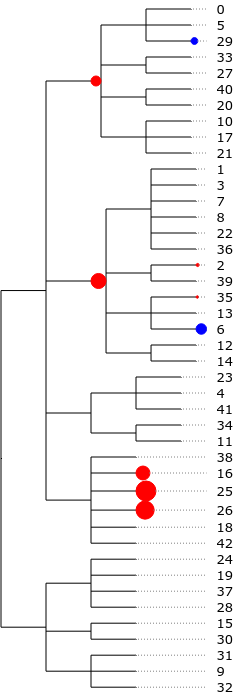

In [12]:
tasccoda_model.plot_draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Hpoly.Day10]",
    show_leaf_effects=False,
    show_legend=False,
)

In [1]:
tasccoda_model.plot_effects_barplot(
    tasccoda_data, modality_key="coda", covariates="condition"
)

NameError: name 'tasccoda_model' is not defined

In [14]:
kwargs = {"ncols": 3, "wspace": 0.25, "vcenter": 0, "vmax": 1.5, "vmin": -1.5}
tasccoda_model.plot_effects_umap(
    tasccoda_data,
    effect_name=[
        "effect_df_condition[T.Salmonella]",
        "effect_df_condition[T.Hpoly.Day3]",
        "effect_df_condition[T.Hpoly.Day10]",
    ],
    cluster_key="nsbm_level_1",
    **kwargs,
)
sc.pl.umap(
    tasccoda_data["rna"], color=["cell_label", "nsbm_level_1"], ncols=2, wspace=0.5
)

# Without labeled clusters

In [1]:
import pertpy as pt
import scanpy as sc
milo = pt.tl.Milo()
# adata = pt.dt.haber_2017_regions()
# adata.write_h5ad("harber_2017.h5ad")
adata = sc.read_h5ad("harber_2017.h5ad")
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 9842 × 15215
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label'
    milo:	0 x 0

In [2]:
# use logcounts to calculate PCA and neighbors
adata.layers["counts"] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=3000, subset=False
)  # 3k genes as used by authors for clustering

sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


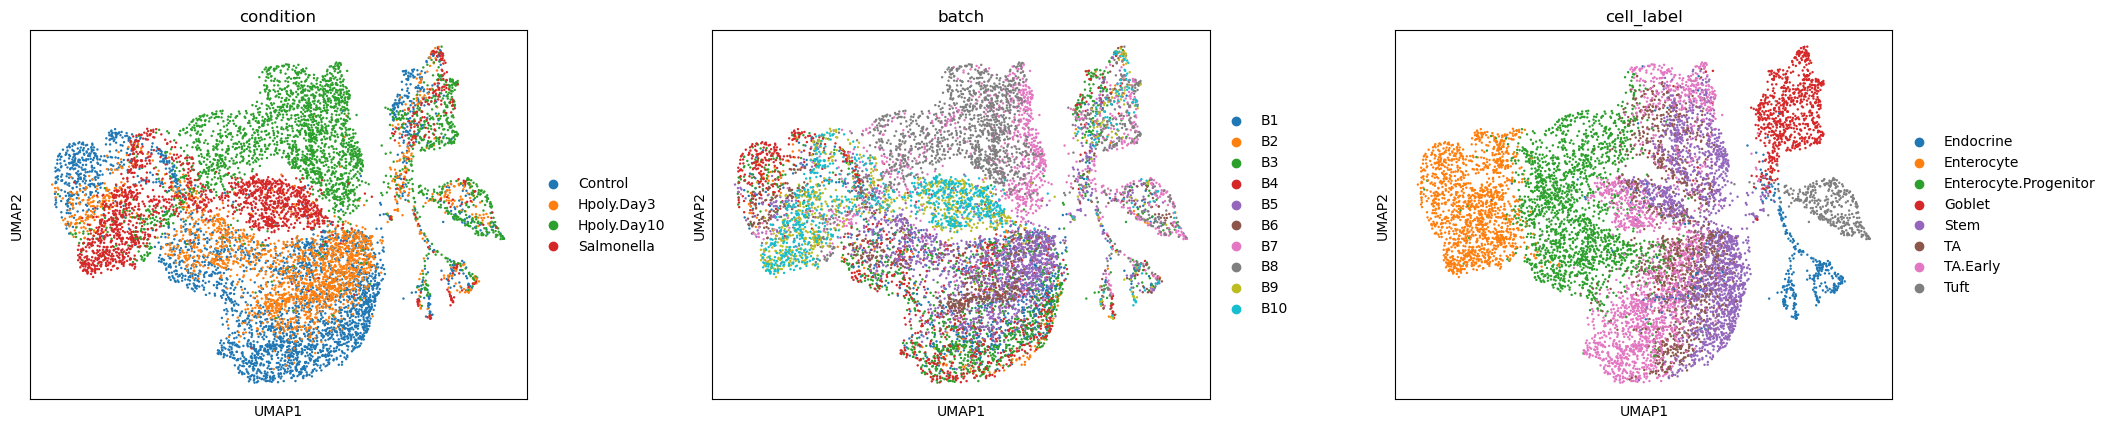

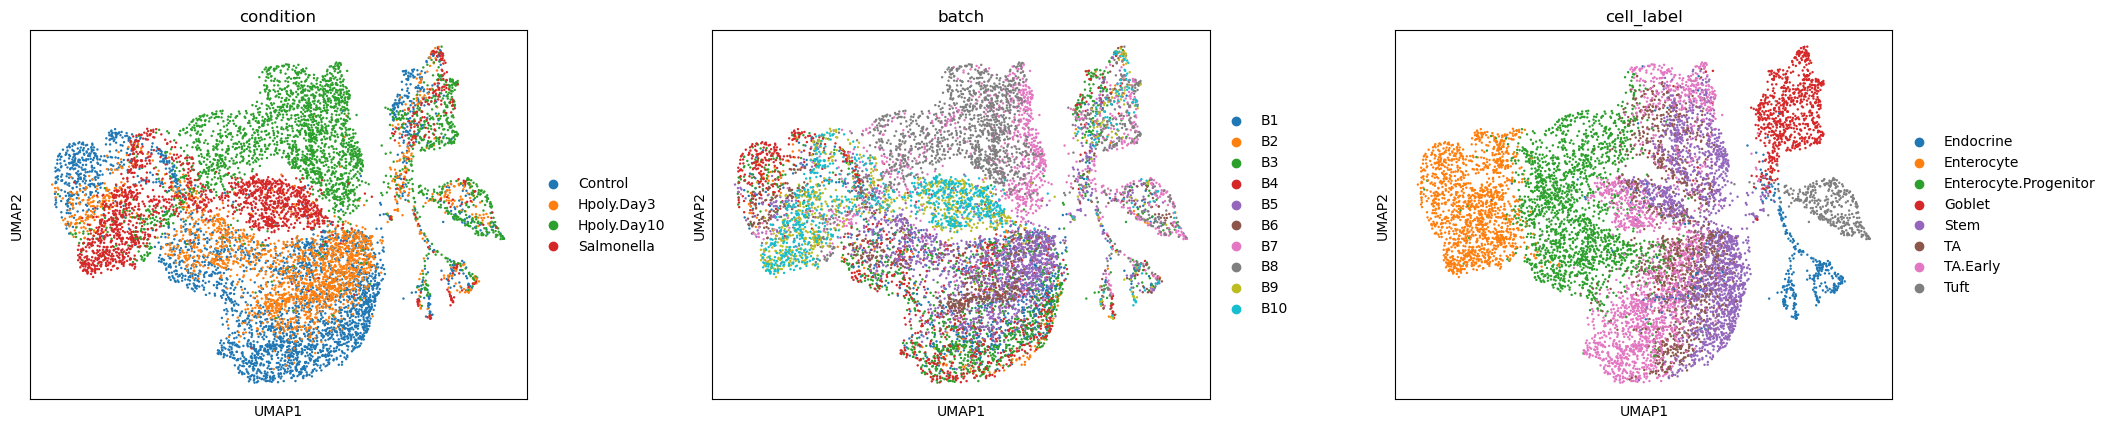

In [3]:
import matplotlib.pyplot as plt
sc.pl.umap(adata, color=["condition", "batch", "cell_label"], ncols=3, wspace=0.25,return_fig = True)


In [4]:
import scvi
import numpy as np
adata_scvi = adata[:, adata.var["highly_variable"]].copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="batch")
model_scvi = scvi.model.SCVI(adata_scvi)
max_epochs_scvi = int(np.min([round((20000 / adata.n_obs) * 400), 400]))
model_scvi.train(max_epochs=max_epochs_scvi)
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_

In [5]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

/home/luosg/miniconda3/envs/scRNAseq_rpy2_1/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


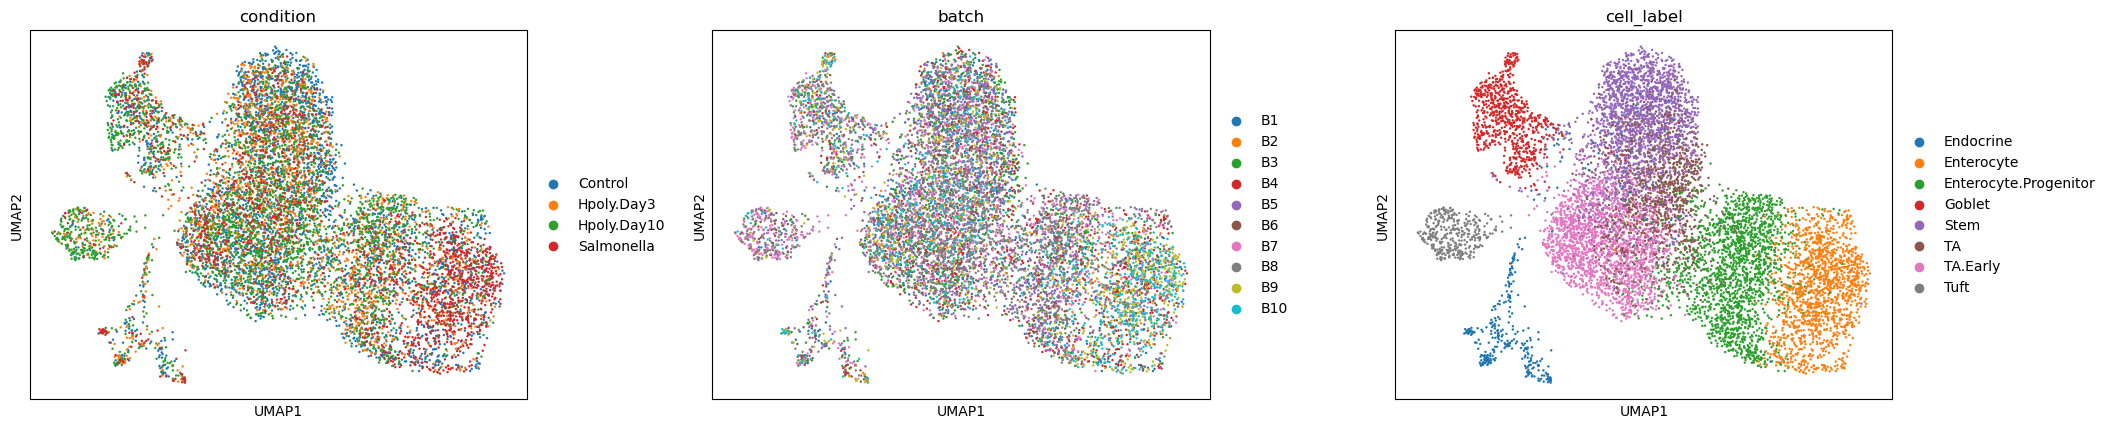

In [6]:
sc.pl.umap(adata, color=["condition", "batch", "cell_label"], ncols=3, wspace=0.25)